In this notebook, we will try using autoencoders to solve the anomaly detection problem. For data exploring and a solution using linear regression, please take a look on the notebook data_exploring_linear_model.

In [403]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [404]:
df = pd.read_csv('data/T1.csv')

In [405]:
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [406]:
# Rename columns
df = df.rename(columns = {'LV ActivePower (kW)'	: 'ActivePower'})
df = df.rename(columns = {'Theoretical_Power_Curve (KWh)'	: 'TheoreticalPower'})
df = df.rename(columns = {'Wind Direction (°)'	: 'WindDirection'})
df = df.rename(columns = {'Wind Speed (m/s)'	: 'WindSpeed'})

In [407]:
# Convert Date/Time feature to format day-month-year hour:minute
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format = '%d %m %Y %H:%M')
df['Date'] = df['Date/Time'].dt.date
df['Time'] = df['Date/Time'].dt.time

In [408]:
# Split date data
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [409]:
# Add the season feature
def get_season(month):
    if month in [12, 1, 2]:
        return 3
    elif month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    else: 
        return 2

In [410]:
df['Season'] = df['Month'].apply(get_season)

In [411]:
# Sort the unique time values and create a mapping of sorted times to numerical labels
sorted_times = sorted(df['Time'].unique())
time_to_label = {time: label for label, time in enumerate(sorted_times)}

# Map the 'Time' column to its numerical label based on the sorted order
df['EncodedTime'] = df['Time'].map(time_to_label)

In [412]:
df.drop(columns=['Date/Time', 'Date', 'Time'], inplace=True)

In [413]:
df.head()

,ActivePower,WindSpeed,TheoreticalPower,WindDirection,Day,Month,Year,Season,EncodedTime
0,380.047791,5.311336,416.328908,259.994904,1,1,2018,3,0
1,453.769196,5.672167,519.917511,268.641113,1,1,2018,3,1
2,306.376587,5.216037,390.900016,272.564789,1,1,2018,3,2
3,419.645905,5.659674,516.127569,271.258087,1,1,2018,3,3
4,380.650696,5.577941,491.702972,265.674286,1,1,2018,3,4


In [414]:
X = df.values
y = X

In [415]:
X.shape

(50530, 9)

In [416]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [417]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40424, 9)
(40424, 9)
(10106, 9)
(10106, 9)


In [418]:
df.head()

,ActivePower,WindSpeed,TheoreticalPower,WindDirection,Day,Month,Year,Season,EncodedTime
0,380.047791,5.311336,416.328908,259.994904,1,1,2018,3,0
1,453.769196,5.672167,519.917511,268.641113,1,1,2018,3,1
2,306.376587,5.216037,390.900016,272.564789,1,1,2018,3,2
3,419.645905,5.659674,516.127569,271.258087,1,1,2018,3,3
4,380.650696,5.577941,491.702972,265.674286,1,1,2018,3,4


In [419]:
# Convert to pytorch
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

We have done a data preprocessing for the model. Let's now define the model.

In [420]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [445]:
import torch.optim as optim

input_size = X_train.shape[1]
hidden_size = 16
model = Autoencoder(input_size, hidden_size)

# Define loss function and optimizer
learning_rate = 0.03
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [446]:
# Traing the model
n_epochs = 3
for i in range(n_epochs):
    MSELoss = 0
    for x, y in zip(X_train, y_train):
        output = model.forward(x)
        loss = criterion(output, y)
        MSELoss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i % 1 == 0:
        print(f"Step {i}")
        print(f"MSELoss: {MSELoss/X_train.shape[0]}")

Step 0
MSELoss: 482360.4622006729
Step 1
MSELoss: 466869.1986142205


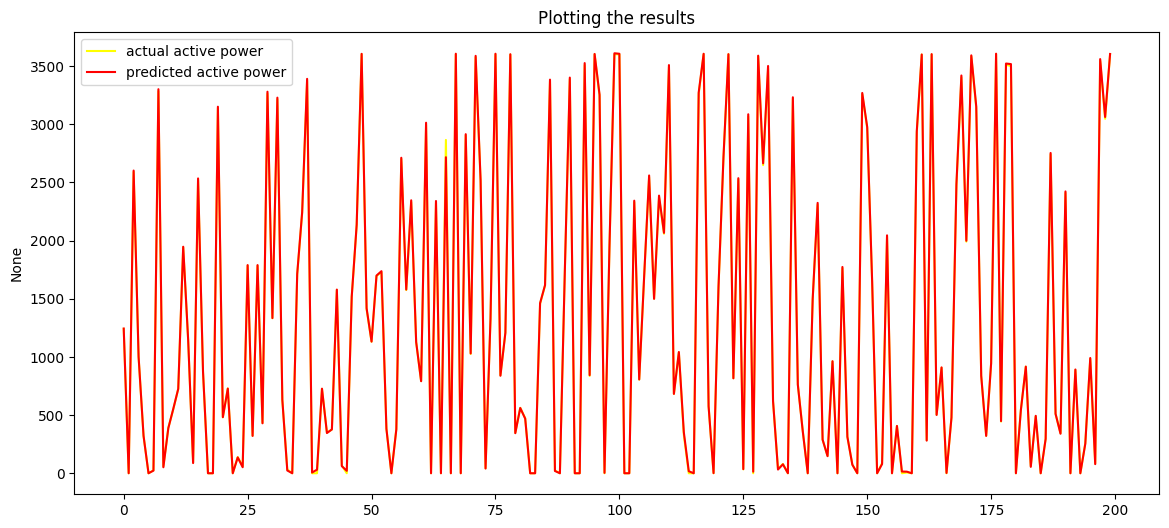

In [431]:
import matplotlib.pyplot as plt
import seaborn as sns

reconstructed_data = []
for x in X_train:
    r_data = model(x).detach().numpy()
    reconstructed_data.append(r_data[0])

plt.figure(figsize=(14, 6))
length = 200
sns.lineplot(x = range(length), y = y_train[200:400, 0], label = 'actual active power', color = "yellow")
sns.lineplot(x = range(length), y = reconstructed_data[200:400], label = 'predicted active power', color = "r")
plt.title('Plotting the results')
plt.legend()
plt.show()

We can see that it might be overfitting. Let's try it on test set and plot it.

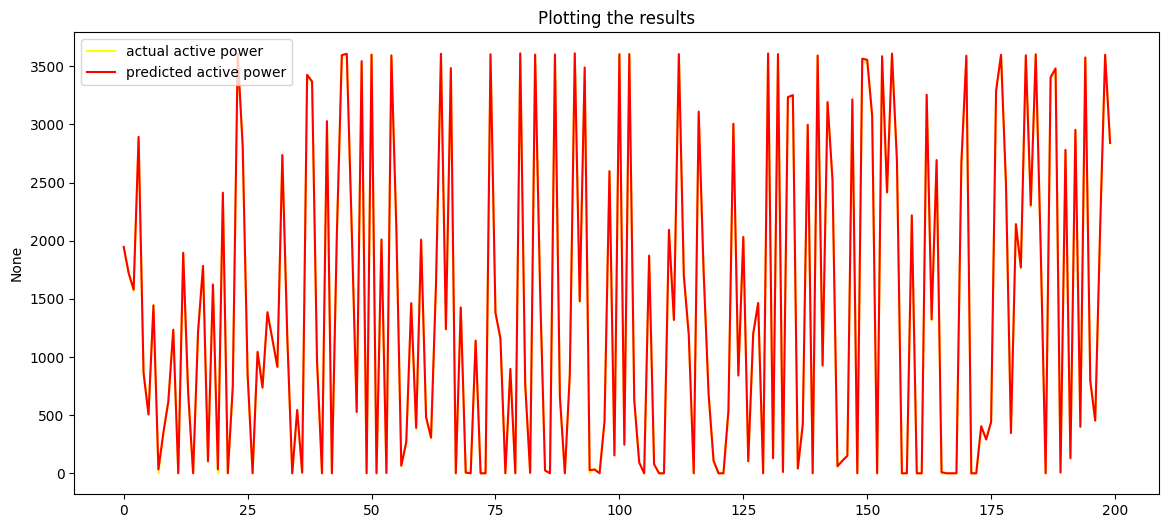

In [432]:
reconstructed_data = []
for x in X_test:
    r_data = model(x).detach().numpy()
    reconstructed_data.append(r_data[0])

plt.figure(figsize=(14, 6))
length = 200
sns.lineplot(x = range(length), y = y_test[0:200, 0], label = 'actual active power', color = "yellow")
sns.lineplot(x = range(length), y = reconstructed_data[0:200], label = 'predicted active power', color = "r")
plt.title('Plotting the results')
plt.legend()
plt.show()

As we can see, the model learns too well and it does not help to detect anomalies.